In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# Import

In [2]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

Using plaidml.keras.backend backend.


# MNIST 데이터 로드

In [3]:
mnist = keras.datasets.mnist

In [4]:
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)

In [7]:
x_train = x_train / 127.5 - 1

In [8]:
x_train.min(), x_train.max()

(-1.0, 1.0)

# Encoder 정의

In [9]:
encoder_input = keras.Input(shape=(28, 28, 1))

# 28 X 28
x = Conv2D(32, 3, padding='same')(encoder_input) 
x = BatchNormalization()(x)
x = LeakyReLU()(x) 

# 28 X 28 -> 14 X 14
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x) 
x = LeakyReLU()(x) 

# 14 X 14 -> 7 X 7
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 17 X 7
x = Conv2D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

# 2D 좌표로 표기하기 위하여 2를 출력값으로 지정합니다.
encoder_output = Dense(2)(x)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


In [10]:
encoder = Model(encoder_input, encoder_output)

### Encoder 모델 정의

In [11]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

# Decoder

In [12]:
# Input으로는 2D 좌표가 들어갑니다.
decoder_input = keras.Input(shape=(2, ))

# 2D 좌표를 7*7*64 개의 neuron 출력 값을 가지도록 변경합니다.
x = Dense(7*7*64)(decoder_input)
x = Reshape( (7, 7, 64))(x)

# 7 X 7 -> 7 X 7
x = Conv2DTranspose(64, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 7 X 7 -> 14 X 14
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 14 X 14 -> 28 X 28
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 28 X 28 -> 28 X 28
x = Conv2DTranspose(32, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 최종 output
decoder_output = Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh')(x)

### Decoder 모델 정의

In [13]:
decoder = Model(decoder_input, decoder_output)

In [14]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
__________

# Hyperparameter 정의

In [15]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32

# Encoder + Decoder

In [16]:
encoder_in = keras.Input(shape=(28, 28, 1))
x = encoder(encoder_in)
decoder_out = decoder(x)

# Auto Encoder 모델 최종 정의

In [17]:
auto_encoder = Model(encoder_in, decoder_out)

# Auto Encoder 모델 compile

In [18]:
auto_encoder.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss=keras.losses.mean_squared_error)

- 체크포인트 정의

In [19]:
checkpoint_path = 'tmp/01-basic-auto-encoder-MNIST.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                            save_best_only=True,
                            save_weights_only=True,
                            monitor='loss',
                            verbose=1)

- 학습 시작

In [20]:
auto_encoder.fit(x_train, x_train,
                batch_size=BATCH_SIZE,
                epochs=100,
                callbacks=[checkpoint],
                )

Epoch 1/100
 7776/60000 [==>...........................] - ETA: 3:11 - loss: 0.9229

KeyboardInterrupt: 

In [29]:
auto_encoder.load_weights(checkpoint_path)

# 시각화

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# MNIST 이미지에 대하여 x, y 좌표로 뽑아낸다.
xy = encoder.predict(x_train)

In [32]:
xy.shape, y_train.shape

((60000, 2), (60000,))

# 인코더의 X, Y좌표 값을 시각화

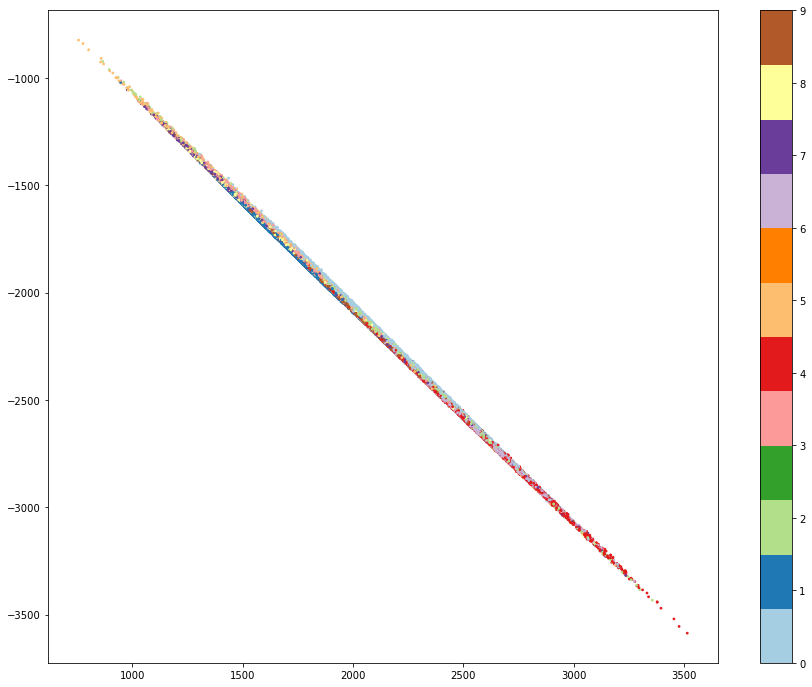

In [33]:
plt.figure(figsize=(15, 12))
plt.scatter(x=xy[:, 0], y=xy[:, 1], c=y_train, cmap=plt.get_cmap('Paired'), s=3)
plt.colorbar()
plt.show()

# Auto Encoder를 통한 이미지 재생성 성능 비교 시각화

In [34]:
decoded_images = auto_encoder.predict(x_train)

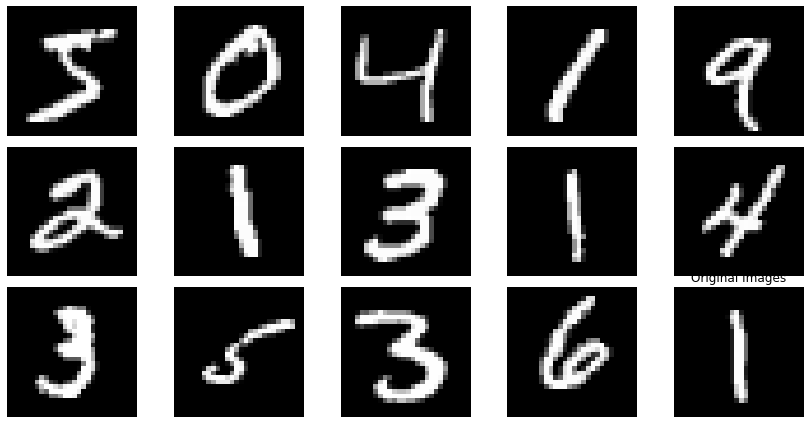

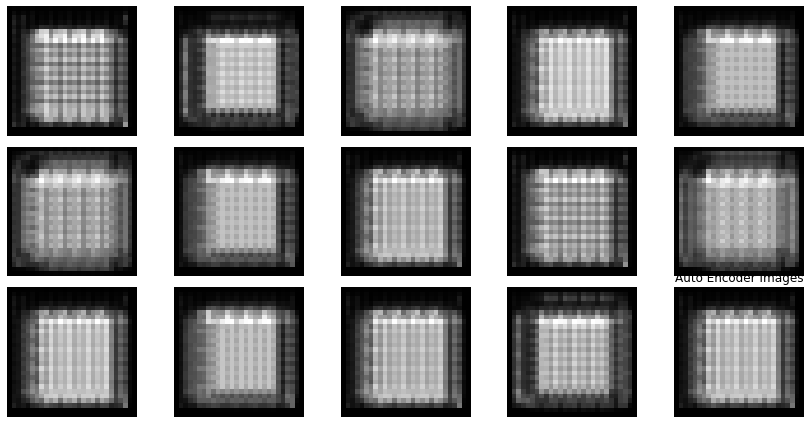

In [36]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Original Images')
plt.show()

fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Auto Encoder Images')
plt.show()